In [1]:
import neuro_morpho_toolbox as nmt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import os
import re
import pickle
# from timeit import default_timer as timer
# from sklearn.preprocessing import scale
# from sklearn.manifold import Isomap, TSNE
# from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# import seaborn as sns
# from scipy.stats import mannwhitneyu

# # from pysankey import sankey

# from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering, Birch
# from sklearn.neighbors import NearestNeighbors
# from sklearn.feature_selection import mutual_info_classif
# from sklearn import metrics
# import igraph
# from math import ceil
# from timeit import default_timer as timer
# import subprocess
# from pathlib import Path
# from numpy import linalg as LA

# plot nrrd
import SimpleITK as sitk

%matplotlib inline


In [2]:
def get_location_tables_by_path(swc_path, loc_path, soma_path, vis_path, zyx, flip_axes=[]):
    swc_files = nmt.get_sample_list(swc_path, "swc")
    for i,swc_file in enumerate(swc_files):
        print("%d/%d %s" % (i+1, len(swc_files), swc_file))
        neuron = nmt.swc(swc_path + swc_file, zyx=zyx)
        for flip_axis in flip_axes:
            neuron.flip(flip_axis, 
                        axis_max=nmt.annotation.size[flip_axis]*nmt.annotation.space[flip_axis]
                       )
        # 1. Soma (XYZ) df
        soma_df = neuron.get_segments()
        if 0 in soma_df.index.tolist():
            if soma_df.loc[0, "type"]==1:
                soma_df = pd.DataFrame(soma_df.loc[0, ["x", "y", "z"]]).transpose()
                soma_df.to_csv(soma_path+swc_file+".csv")
        else:
            print("Soma not found:\t%s" % swc_file)
        
        # 2. location df (including axon, soma, dendrite)
        region_df = neuron.get_region_matrix(nmt.annotation, nmt.bs)
        # Select non-zero regions to export
        region_df = region_df[np.sum(region_df[["soma", "axon", "apical dendrite", "(basal) dendrite"]], axis=1) > 0]
        # Add region names for reading
        region_df["Abbrevation"] = nmt.bs.level.loc[region_df.structure_id, "Abbrevation"].tolist()
        # Sort for reading
        region_df = region_df.sort_values(["soma", "(basal) dendrite", "axon"], ascending=False)
        region_df.index = range(len(region_df))
        region_df.to_csv(loc_path+swc_file+".csv")
        # Save for visualization
        neuron.scale([1/10, 1/10, 1/10])
        neuron.save(vis_path + swc_file)
    return


## fMOST_Claustrum

In [3]:
swc_path = "../data/CCF/mapped/swc/Whole/"
loc_path = "../data/CCF/mapped/location/Whole/"
soma_path = "../data/CCF/mapped/location/Soma/"
vis_path = "../data/CCF/mapped/swc/Visualization/"
zyx=False
flip_axes = []

get_location_tables_by_path(swc_path, loc_path, soma_path, vis_path, zyx, flip_axes)

1/100 236174_04229_04328_X13663_Y8589_QCed.swc
2/100 17109_2601-2700-X10213-Y8783_QCed.ano.eswc
3/100 17782_3651_X35286_Y18512_QCed.swc
4/100 236174_4429_04528_X13147_Y8003_QCed.swc
5/100 17781_6228_x12697_y8412_QCed.swc
6/100 236174_3729_03828_X15151_Y26698_QCed.swc
7/100 17109_6301_6400_X4756_Y24516_QCed.swc
8/100 236174_03229_03328_X11950_Y11335_QCed.swc
9/100 236174_3970_04170_X13439_Y8678_QCed.swc
10/100 236174_3729_03828_X13645_Y9551_QCed.swc
11/100 17109_3701_03800_X9228_Y26684_QCed.swc
12/100 17109_7001-7100-X5738-Y6470_QCed.ano.eswc
13/100 17781_3139_X20033_Y17506_QCed.swc
14/100 17109_2301_2400_X8535_Y23051_QCed.swc
15/100 17781_3668_x9453_y17266_QCed.swc
16/100 236174_7077_07089_X14579_Y30892_QCed.swc
17/100 236174_03929_04028_X12721_Y8845_QCed.swc
18/100 17109_01901_02000_X9602_Y10508_QCed.swc
19/100 17109_1801_1900_X6698_Y12550_QCed.swc
20/100 17109_2601_2700_X9498_Y8169_QCed.swc
21/100 236174_3829_03928_X16301_Y26647_QCed.swc
22/100 236174_03529_03628_X13394_Y26567_QCed.s

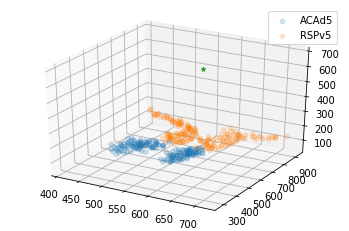

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_region = ["ACAd5", "RSPv5"]
for i, cur_region in enumerate(plot_region):
    structure_id = nmt.bs.name_to_id(cur_region)
    if structure_id<0:
        next
    xs, ys, zs = np.where(nmt.annotation.array==structure_id)
    lab = np.random.choice(np.arange(len(xs)), np.min([len(xs), 200]), replace=False)
    ax.scatter(zs[lab], xs[lab], ys[lab], label=cur_region, alpha=0.2)

ax.legend()

ax.scatter(615, 603, 679, marker="*")
